C:\Users\user\AppData\Local\Temp\ipykernel_11784\2607477387.py:41: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 8734, number of used features: 5
[LightGBM] [Info] Start training from score 10.096655


C:\Users\user\AppData\Local\Temp\ipykernel_11784\2607477387.py:70: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_idx = pd.date_range(start=start_forecast + pd.Timedelta(hours=1),
C:\Users\user\AppData\Local\Temp\ipykernel_11784\2607477387.py:78: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  future_df['is_holiday']      = future_df['ds'].dt.normalize().isin(be_holidays).astype(int)



--- 24-Hour Forecast ---
                    ds       yhat
0  2025-05-07 00:00:00   0.387741
1  2025-05-07 01:00:00   0.349154
2  2025-05-07 02:00:00   0.162901
3  2025-05-07 03:00:00   0.162901
4  2025-05-07 04:00:00   0.234956
5  2025-05-07 05:00:00   0.265291
6  2025-05-07 06:00:00   0.405525
7  2025-05-07 07:00:00  16.313202
8  2025-05-07 08:00:00  50.271523
9  2025-05-07 09:00:00  61.229896
10 2025-05-07 10:00:00  47.209465
11 2025-05-07 11:00:00  33.485444
12 2025-05-07 12:00:00  18.832649
13 2025-05-07 13:00:00  16.154727
14 2025-05-07 14:00:00  14.977254
15 2025-05-07 15:00:00  11.118843
16 2025-05-07 16:00:00   5.439378
17 2025-05-07 17:00:00   2.654730
18 2025-05-07 18:00:00   1.060691
19 2025-05-07 19:00:00   0.368795
20 2025-05-07 20:00:00   0.305145
21 2025-05-07 21:00:00   0.223653
22 2025-05-07 22:00:00   0.170383
23 2025-05-07 23:00:00   0.162901
24 2025-05-08 00:00:00   0.162901
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00

C:\Users\user\AppData\Local\Temp\ipykernel_11784\2607477387.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_bt['yhat'] = model_bt.predict(X_test_bt)


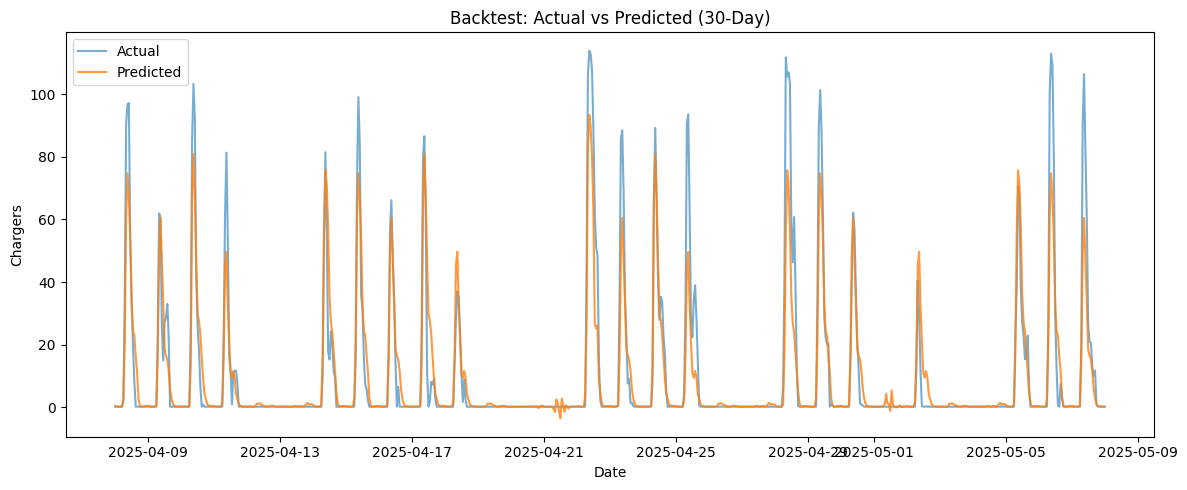

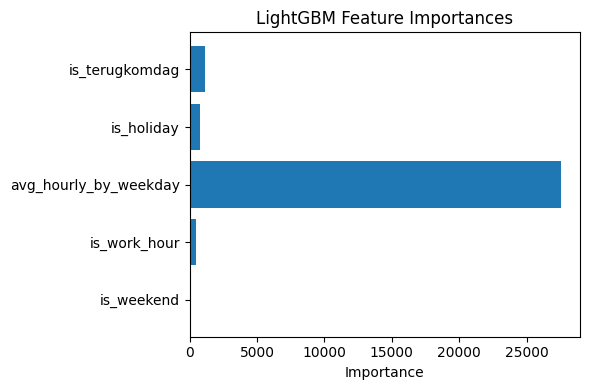

In [9]:
import pandas as pd
import numpy as np
import holidays
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1. Load & preprocess data ---
df = pd.read_csv("./Charging_data_cleaned.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={"Chargers": "y"})

# --- 2. Define “terugkomdagen” (mandatory in-office days) ---
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]
tkd = pd.to_datetime(terugkomdagen).normalize()
df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)

# --- 3. Feature engineering ---
df['weekday']      = df['ds'].dt.weekday
df['hour']         = df['ds'].dt.hour
df['is_weekend']   = (df['weekday'] >= 5).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

# Avg consumption by weekday & hour
avg_map = (
    df.groupby(['weekday','hour'])['y']
      .mean()
      .reset_index()
      .rename(columns={'y':'avg_hourly_by_weekday'})
)
df = df.merge(avg_map, on=['weekday','hour'], how='left')

# Holiday flag for Belgium
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())
df['is_holiday'] = df['ds'].dt.normalize().isin(be_holidays).astype(int)

# --- 4. Define windows & feature list ---
latest         = df['ds'].max()
start_forecast = latest - pd.Timedelta(hours=25)
start_backtest = latest - pd.Timedelta(days=30)

FEATURES = [
    'is_weekend',
    'is_work_hour',
    'avg_hourly_by_weekday',
    'is_holiday',
    'is_terugkomdag'
]

# --- 5. 24-Hour Forecast with LightGBM ---
train_f = df[df['ds'] < start_forecast]
X_train_f = train_f[FEATURES]
y_train_f = train_f['y']

model_f = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    
)
model_f.fit(X_train_f, y_train_f)

# prepare next 24h features
future_idx = pd.date_range(start=start_forecast + pd.Timedelta(hours=1),
                           end=latest, freq='H')
future_df = pd.DataFrame({'ds': future_idx})
future_df['weekday']      = future_df['ds'].dt.weekday
future_df['hour']         = future_df['ds'].dt.hour
future_df['is_weekend']   = (future_df['weekday'] >= 5).astype(int)
future_df['is_work_hour'] = ((future_df['hour'] >= 8) & (future_df['hour'] <= 18)).astype(int)
future_df = future_df.merge(avg_map, on=['weekday','hour'], how='left')
future_df['is_holiday']      = future_df['ds'].dt.normalize().isin(be_holidays).astype(int)
future_df['is_terugkomdag']  = future_df['ds'].dt.normalize().isin(tkd).astype(int)

future_df['yhat'] = model_f.predict(future_df[FEATURES])
print("\n--- 24-Hour Forecast ---")
print(future_df[['ds','yhat']])



# --- 6. Backtest Last 30 Days (single-shot) ---
train_bt = df[df['ds'] < start_backtest]
test_bt  = df[df['ds'] >= start_backtest]

X_train_bt = train_bt[FEATURES]
y_train_bt = train_bt['y']
X_test_bt  = test_bt[FEATURES]
y_test_bt  = test_bt['y']

model_bt = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)
model_bt.fit(X_train_bt, y_train_bt)

test_bt['yhat'] = model_bt.predict(X_test_bt)

mae  = mean_absolute_error(y_test_bt, test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(y_test_bt, test_bt['yhat']))
r2   = r2_score(y_test_bt, test_bt['yhat'])

print("\n--- Backtest Metrics (Last 30 Days) ---")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.2f}")

plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], y_test_bt,      label='Actual', alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Backtest: Actual vs Predicted (30-Day)")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.legend()
plt.tight_layout()
plt.show()

# ────────────────────────────────────────────────────────────────────────────────
# 9. Feature-importance plot
# ────────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.barh(FEATURES, model_bt.feature_importances_)
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance")
plt.tight_layout(); plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_7080\3661865930.py:21: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 8038, number of used features: 8
[LightGBM] [Info] Start training from score 0.170000

--- Back-test Metrics (Last 30 Days) ---
MAE : 3.38
RMSE: 8.07
R²  : 0.89


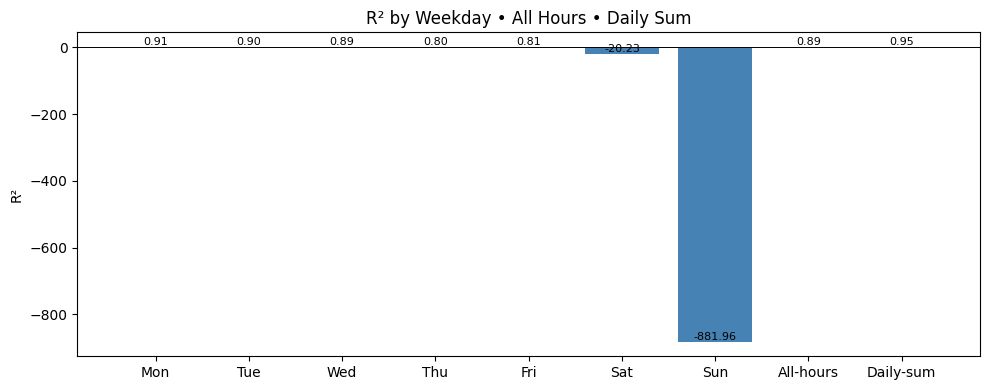

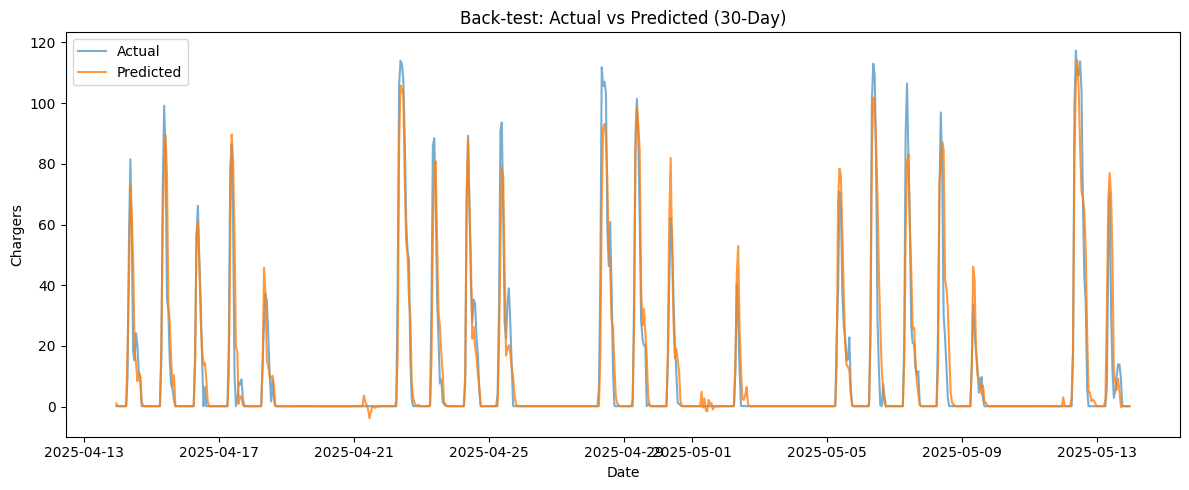

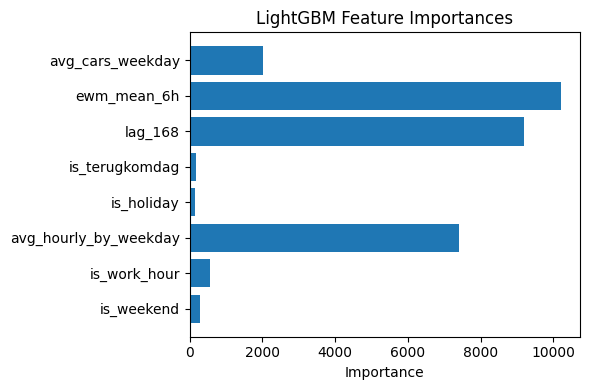

In [22]:
import pandas as pd, numpy as np, holidays, lightgbm as lgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ═════════════════ 1. LOAD DATA ══════════════════════════════════════════════
df = pd.read_csv("./Charging_data_13-05.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Chargers': 'y'})       # hourly kWh

# ═════════════════ 2. CALENDAR FLAGS ════════════════════════════════════════
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]
tkd = pd.to_datetime(terugkomdagen).normalize()
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)
df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)

# ═════════════════ 3. TIME-BASED FEATURES ════════════════════════════════════
df['weekday']      = df['ds'].dt.weekday          # 0 = Mon
df['hour']         = df['ds'].dt.hour
df['is_weekend']   = (df['weekday'] >= 5).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

# ═════════════════ 4. SPLIT TRAIN / TEST (30-day back-test) ═════════════════
start_backtest = df['ds'].max() - pd.Timedelta(days=30)
train_bt = df[df['ds'] < start_backtest].copy()
test_bt  = df[df['ds'] >= start_backtest].copy()

# ═════════════════ 5. TRAIN-ONLY STATISTICS (NO LEAKAGE) ════════════════════
# 5a. Avg energy pattern (weekday, hour) from training set
avg_map = (
    train_bt.groupby(['weekday','hour'])['y']
            .mean()
            .rename('avg_hourly_by_weekday')
            .reset_index()
)
train_bt = train_bt.merge(avg_map, on=['weekday','hour'], how='left')
test_bt  = test_bt .merge(avg_map, on=['weekday','hour'], how='left')

# 5b. Avg cars charged per weekday (training set)
SESSION_KWH      = 9.5
train_bt['cars_charged_hour'] = train_bt['y'] / SESSION_KWH
weekday_car_avg = (
    train_bt.groupby('weekday')['cars_charged_hour']
            .mean()
            .rename('avg_cars_weekday')
            .reset_index()
)
train_bt = train_bt.merge(weekday_car_avg, on='weekday', how='left')
test_bt  = test_bt .merge(weekday_car_avg, on='weekday', how='left')

# ═════════════════ 6. LAG & ROLLING FEATURES (available at prediction time) ═
for frame in (train_bt, test_bt):
    frame['lag_168']     = frame['y'].shift(168)
    frame['lag_168']     = frame['lag_168'].fillna(frame['avg_hourly_by_weekday'])
    frame['ewm_mean_6h'] = frame['y'].shift(1).ewm(span=6, adjust=False).mean()
    frame.loc[frame['is_holiday'] == 1, 'ewm_mean_6h'] = 0

# drop helper column from training
train_bt.drop(columns=['cars_charged_hour'], inplace=True)

# ═════════════════ 7. FINAL FEATURE LIST ════════════════════════════════════
FEATURES = [
    'is_weekend','is_work_hour','avg_hourly_by_weekday',
    'is_holiday','is_terugkomdag',
    'lag_168','ewm_mean_6h',
    'avg_cars_weekday'
]

# ═════════════════ 8. TRAIN & PREDICT ═══════════════════════════════════════
model = lgb.LGBMRegressor(
    objective='quantile', alpha=0.55,
    n_estimators=1000, learning_rate=0.05,
    random_state=42
).fit(train_bt[FEATURES], train_bt['y'])

test_bt['yhat'] = model.predict(test_bt[FEATURES])

# ═════════════════ 9. METRICS ═══════════════════════════════════════════════
mae  = mean_absolute_error(test_bt['y'], test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(test_bt['y'], test_bt['yhat']))
r2   = r2_score(test_bt['y'], test_bt['yhat'])

print("\n--- Back-test Metrics (Last 30 Days) ---")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")

# R² by weekday
weekday_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
r2_by_wd = {weekday_map[d]:
            r2_score(test_bt.loc[test_bt['weekday']==d,'y'],
                     test_bt.loc[test_bt['weekday']==d,'yhat'])
            for d in range(7)}

# R² on daily sums
daily = test_bt.groupby(test_bt['ds'].dt.date).agg(
        y_sum=('y','sum'), yhat_sum=('yhat','sum'))
r2_daily_sum = r2_score(daily['y_sum'], daily['yhat_sum'])

# ═════════════════ 10. R² BAR PLOT ══════════════════════════════════════════
labels = list(r2_by_wd.keys()) + ['All-hours','Daily-sum']
values = list(r2_by_wd.values()) + [r2, r2_daily_sum]

plt.figure(figsize=(10,4))
bars = plt.bar(labels, values, color='steelblue')
plt.axhline(0, color='k', linewidth=0.7)
plt.ylabel("R²")
plt.title("R² by Weekday • All Hours • Daily Sum")
for bar,v in zip(bars,values):
    plt.text(bar.get_x()+bar.get_width()/2, v+0.02, f"{v:.2f}",
             ha='center', va='bottom', fontsize=8)
plt.tight_layout(); plt.show()

# ═════════════════ 11. TIME-SERIES PLOT & FEATURE IMPORTANCE ════════════════
plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], test_bt['y'],    label='Actual',    alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Back-test: Actual vs Predicted (30-Day)")
plt.xlabel("Date"); plt.ylabel("Chargers")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.barh(FEATURES, model.feature_importances_)
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance")
plt.tight_layout(); plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_7080\2186709557.py:40: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 437
[LightGBM] [Info] Number of data points in the train set: 8171, number of used features: 7
[LightGBM] [Info] Start training from score 0.170000


C:\Users\user\AppData\Local\Temp\ipykernel_7080\2186709557.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_idx = pd.date_range(day_start, periods=24, freq='H')
C:\Users\user\AppData\Local\Temp\ipykernel_7080\2186709557.py:96: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  day_df['is_holiday']     = day_df['ds'].dt.normalize().isin(be_holidays).astype(int)



◇ 2025-04-20  (metrics with noon cut-off)
MAE : 0.03   RMSE: 0.06   R²: -660.89


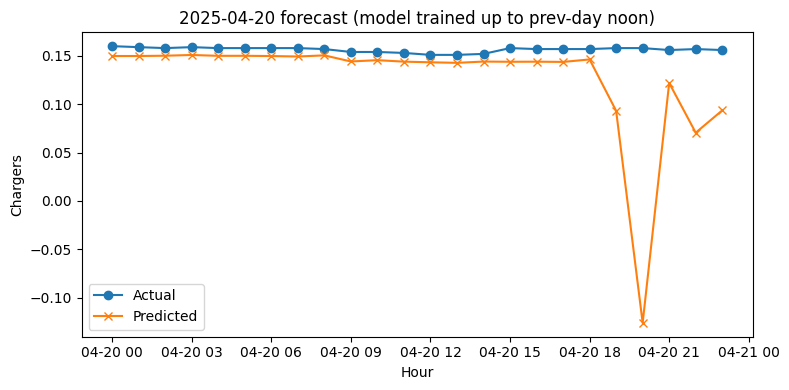

In [19]:
"""
24-hour forecast script (no-leakage, noon cut-off)

• Trains on every hour **up to 12:00 (noon) of the calendar day BEFORE
  TARGET_DATE**.
• Uses those frozen stats to forecast the full 24 h of TARGET_DATE.
• If the day is already in the CSV, prints MAE / RMSE / R²; otherwise it
  just plots the forecast.

Run this at ~12:05 every work-day and you’ll have tomorrow’s forecast
with the latest half-day of metered data included, but no look-ahead.
"""

import pandas as pd, numpy as np, holidays, lightgbm as lgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─── USER SETTINGS ───────────────────────────────────────────────────────────
CSV_PATH     = "./Charging_data_13-05.csv"
TARGET_DATE  = "2025-04-20"          # YYYY-MM-DD  (day you want to forecast)
SESSION_KWH  = 9.5                   # fleet-weighted kWh per vehicle
# ─────────────────────────────────────────────────────────────────────────────

# 1) LOAD DATA
df = pd.read_csv(CSV_PATH)
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Chargers': 'y'})       # hourly kWh

# 2) STATIC CALENDAR FLAGS
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]
tkd = pd.to_datetime(terugkomdagen).normalize()
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)
df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)

# 3) CORE TIME FLAGS
df['weekday']      = df['ds'].dt.weekday          # 0 = Mon
df['hour']         = df['ds'].dt.hour
df['is_weekend']   = (df['weekday'] >= 5).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

# 4) TRAIN/FORECAST SPLIT  (train < previous-day-noon)
cutoff = (pd.Timestamp(TARGET_DATE).normalize()   # 00:00 of target day
          - pd.Timedelta(hours=12))               # => 12:00 previous day
train  = df[df['ds'] < cutoff].copy()
if train.empty:
    raise ValueError("No history before the noon cut-off.")

# 5) TRAIN-ONLY STATISTICS
avg_hourly = (
    train.groupby(['weekday','hour'])['y']
          .mean().rename('avg_hourly_by_weekday')
          .reset_index()
)
train = train.merge(avg_hourly, on=['weekday','hour'], how='left')

train['cars_charged_hour'] = train['y'] / SESSION_KWH
avg_cars_wd = (
    train.groupby('weekday')['cars_charged_hour']
         .mean().rename('avg_cars_weekday')
         .reset_index()
)
train = train.merge(avg_cars_wd, on='weekday', how='left')

# 6) LAG FEATURE (train slice only)
train['lag_168'] = train['y'].shift(168).fillna(train['avg_hourly_by_weekday'])

FEATURES = [
    'is_weekend','is_work_hour','avg_hourly_by_weekday',
    'is_holiday','is_terugkomdag',
    'lag_168','avg_cars_weekday'
]

# 7) TRAIN MODEL
model = lgb.LGBMRegressor(
    objective='quantile', alpha=0.55,
    n_estimators=800, learning_rate=0.05,
    random_state=42
).fit(train[FEATURES], train['y'])

# 8) BUILD 24-H FEATURE FRAME FOR TARGET_DATE
day_start = pd.Timestamp(TARGET_DATE).normalize()
future_idx = pd.date_range(day_start, periods=24, freq='H')

day_df = pd.DataFrame({'ds': future_idx})
day_df['weekday']      = day_df['ds'].dt.weekday
day_df['hour']         = day_df['ds'].dt.hour
day_df['is_weekend']   = (day_df['weekday'] >= 5).astype(int)
day_df['is_work_hour'] = ((day_df['hour'] >= 8) & (day_df['hour'] <= 18)).astype(int)
day_df['is_holiday']     = day_df['ds'].dt.normalize().isin(be_holidays).astype(int)
day_df['is_terugkomdag'] = day_df['ds'].dt.normalize().isin(tkd).astype(int)

day_df = day_df.merge(avg_hourly, on=['weekday','hour'], how='left')
day_df = day_df.merge(avg_cars_wd, on='weekday', how='left')

# lag_168 (value 7 days ago from training slice)
lag_df = train[['ds','y']].copy()
lag_df['ds'] = lag_df['ds'] + pd.Timedelta(days=7)
lag_df = lag_df.rename(columns={'y':'lag_168'})
day_df = day_df.merge(lag_df, on='ds', how='left')
day_df['lag_168'] = day_df['lag_168'].fillna(day_df['avg_hourly_by_weekday'])

# 9) FORECAST
preds = []
for i in range(24):
    row = day_df.iloc[[i]].copy()
    yhat = model.predict(row[FEATURES])[0]
    preds.append(yhat)

day_df['yhat'] = preds

# 10) METRICS IF ACTUALS EXIST
actual_mask = (df['ds'] >= day_start) & (df['ds'] < day_start + pd.Timedelta(days=1))
if actual_mask.any():
    actual = df.loc[actual_mask, ['ds','y']].reset_index(drop=True)
    merged = actual.merge(day_df[['ds','yhat']], on='ds')
    mae  = mean_absolute_error(merged['y'], merged['yhat'])
    rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
    r2   = r2_score(merged['y'], merged['yhat'])
    print(f"\n◇ {TARGET_DATE}  (metrics with noon cut-off)")
    print(f"MAE : {mae:.2f}   RMSE: {rmse:.2f}   R²: {r2:.2f}")
else:
    print(f"\n◇ {TARGET_DATE} is future-only → metrics not available.")

# 11) PLOT FORECAST
plt.figure(figsize=(8,4))
if actual_mask.any():
    plt.plot(merged['ds'], merged['y'],   label='Actual',    marker='o')
    plt.plot(merged['ds'], merged['yhat'],label='Predicted', marker='x')
else:
    plt.plot(day_df['ds'], day_df['yhat'], label='Forecast', marker='x')
plt.title(f"{TARGET_DATE} forecast (model trained up to prev-day noon)")
plt.xlabel("Hour"); plt.ylabel("Chargers")
plt.legend(); plt.tight_layout(); plt.show()


In [27]:
import pandas as pd, numpy as np, holidays, lightgbm as lgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─────────────────────── 1  LOAD DATA ───────────────────────
df = pd.read_csv("Charging_data_cleaned.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Chargers': 'y'})    # hourly kWh

# ─────────────────────── 2  STATIC FLAGS ─────────────────────
tkd = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]).normalize()
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)
df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)

# core time flags
df['weekday']      = df['ds'].dt.weekday
df['hour']         = df['ds'].dt.hour
df['is_weekend']   = (df['weekday'] >= 5).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

SESSION_KWH = 9.5                         # average energy per vehicle-session

# 30-day evaluation window
start_eval = df['ds'].max() - pd.Timedelta(days=30)
days_iter  = pd.date_range(start_eval.normalize(),
                           df['ds'].max().normalize(),
                           freq='D')

all_preds = []                            # collect daily predictions

for day in days_iter:
    day_start = pd.Timestamp(day)         # 00:00 of target day
    day_end   = day_start + pd.Timedelta(days=1)

    # ──  TRAIN slice: everything before 00:00 of this day  ──
    train = df[df['ds'] < day_start].copy()
    # derive weekday/hour mean & weekday car average on **train only**
    avg_map = (train.groupby(['weekday','hour'])['y']
                     .mean().rename('avg_hourly_by_weekday')
                     .reset_index())
    train['lag_168'] = train['y'].shift(168).fillna(
        train['y'].mean())                      # fallback mean
    train.loc[train['is_holiday'] == 1, 'ewm_mean_6h'] = 0
    train = train.merge(avg_map, on=['weekday','hour'], how='left')
    train['avg_cars_weekday'] = (
        train.groupby('weekday')['y'].transform('mean') / SESSION_KWH
    )

    FEATURES = [
        'is_weekend','is_work_hour','avg_hourly_by_weekday',
        'is_holiday','is_terugkomdag',
        'lag_168','avg_cars_weekday'
    ]

    model = lgb.LGBMRegressor(
        objective='quantile', alpha=0.55,
        n_estimators=800, learning_rate=0.05,
        random_state=42
    ).fit(train[FEATURES], train['y'])

    # ──  BUILD feature frame for the 24 h of this day  ──
    day_df = df[(df['ds'] >= day_start) & (df['ds'] < day_end)].copy()
    day_df = day_df.merge(avg_map, on=['weekday','hour'], how='left')

    lag_df = train[['ds','y']].copy()
    lag_df['ds'] = lag_df['ds'] + pd.Timedelta(days=7)
    lag_df.rename(columns={'y':'lag_168'}, inplace=True)
    day_df = day_df.merge(lag_df, on='ds', how='left')
    day_df['lag_168'] = day_df['lag_168'].fillna(
        day_df['avg_hourly_by_weekday'])

    last_ewm = train['ewm_mean_6h'].iloc[-1]
    day_df['ewm_mean_6h'] = np.where(day_df['is_holiday'] == 1, 0, last_ewm)

    cars_map = (train.groupby('weekday')['y'].mean() / SESSION_KWH
                ).rename('avg_cars_weekday').reset_index()
    day_df = day_df.merge(cars_map, on='weekday', how='left')

    # predict all 24 rows
    day_df['yhat'] = model.predict(day_df[FEATURES])
    all_preds.append(day_df[['ds','y','yhat','weekday']])

# ────────── CONCAT results & evaluate ──────────
test_bt = pd.concat(all_preds).sort_values('ds').reset_index(drop=True)

mae  = mean_absolute_error(test_bt['y'], test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(test_bt['y'], test_bt['yhat']))
r2   = r2_score(test_bt['y'], test_bt['yhat'])
print(f"\nRolling one-day forecast over 30 d  →  MAE={mae:.2f}  RMSE={rmse:.2f}  R²={r2:.2f}")

# optional: plot or weekday metrics …


plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], test_bt['y'],    label='Actual',    alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Back-test: Actual vs Predicted (30-Day)")
plt.xlabel("Date"); plt.ylabel("Chargers")
plt.legend(); plt.tight_layout(); plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Charging_data_cleaned.csv'

C:\Users\user\AppData\Local\Temp\ipykernel_7080\2554053739.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['ds'].dt.normalize().isin(be_holidays).astype(int)
11:46:43 - cmdstanpy - INFO - Chain [1] start processing
11:46:45 - cmdstanpy - INFO - Chain [1] done processing
11:46:45 - cmdstanpy - INFO - Chain [1] start processing
11:46:46 - cmdstanpy - INFO - Chain [1] done processing
11:46:47 - cmdstanpy - INFO - Chain [1] start processing
11:46:48 - cmdstanpy - INFO - Chain [1] done processing
11:46:48 - cmdstanpy - INFO - Chain [1] start processing
11:46:50 - cmdstanpy - INFO - Chain [1] done processing
11:46:51 - cmdstanpy - INFO - Chain [1] start processing
11:46:52 - cmdstanpy - INFO - Chain [1] done processing
11:46:53 - cmdstanpy - INFO - Chain [1] st


Rolling one-day forecast over 30 d  →  MAE=6.55  RMSE=13.28  R²=0.70


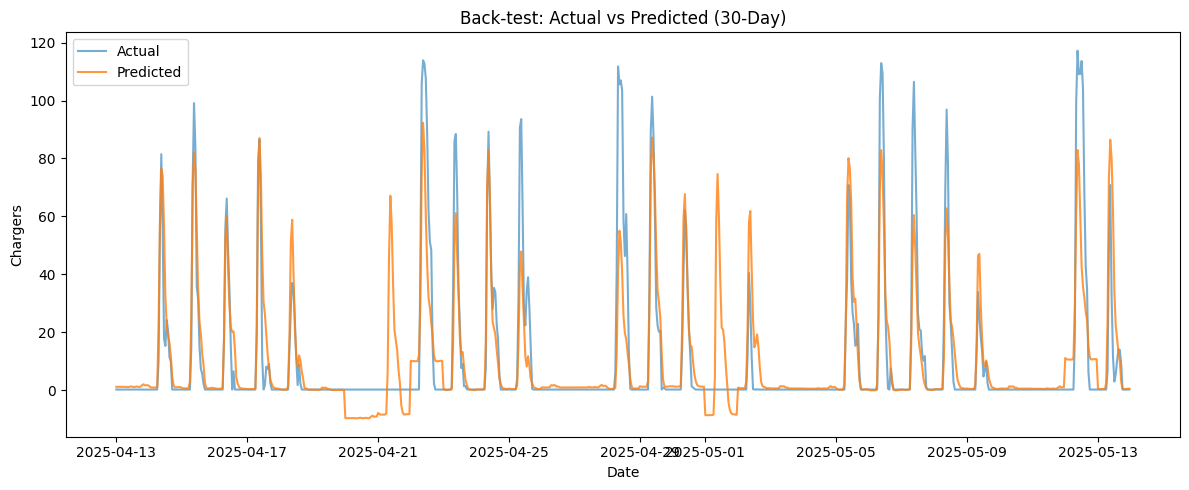

In [25]:
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─────────────────────── 1  LOAD DATA ───────────────────────
df = pd.read_csv("./Charging_data_13-05.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Chargers': 'y'})  # hourly kWh

# ─────────────────────── 2  STATIC FLAGS ─────────────────────
tkd = pd.to_datetime([
    "2023-09-13", "2023-10-26", "2023-11-14", "2023-12-20",
    "2024-01-12", "2024-02-07", "2024-03-14", "2024-04-16",
    "2024-05-13", "2024-06-07", "2024-10-22", "2024-11-28",
    "2024-12-18", "2025-01-10", "2025-02-13", "2025-03-18",
    "2025-04-22", "2025-05-12", "2025-06-06",
]).normalize()
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

# core time flags
df['weekday'] = df['ds'].dt.weekday
df['hour'] = df['ds'].dt.hour
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

df['is_holiday'] = df['ds'].dt.normalize().isin(be_holidays).astype(int)
df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

SESSION_KWH = 9.5  # average energy per vehicle-session

# 30-day evaluation window
start_eval = df['ds'].max() - pd.Timedelta(days=30)
days_iter = pd.date_range(start_eval.normalize(),
                           df['ds'].max().normalize(),
                           freq='D')

FEATURES = [
    'is_weekend', 'is_work_hour', 'avg_hourly_by_weekday',
    'is_holiday', 'is_terugkomdag', 'lag_168', 'avg_cars_weekday'
]

all_preds = []  # collect daily predictions

for day in days_iter:
    day_start = pd.Timestamp(day)  # 00:00 of target day
    day_end = day_start + pd.Timedelta(days=1)

    # ── TRAIN slice: everything before 00:00 of this day ──
    train = df[df['ds'] < day_start].copy()

    # derive weekday/hour mean & weekday car average on **train only**
    avg_map = (train.groupby(['weekday', 'hour'])['y']
                     .mean().rename('avg_hourly_by_weekday')
                     .reset_index())
    train = train.merge(avg_map, on=['weekday', 'hour'], how='left')

    # 7-day lag (168 hours)
    train['lag_168'] = train['y'].shift(168)
    train['lag_168'] = train['lag_168'].fillna(train['y'].mean())  # fallback

    # simple 6-hour EWM on non-holidays (kept only for continuity)
    train['ewm_mean_6h'] = train['y'].ewm(span=6).mean()
    train.loc[train['is_holiday'] == 1, 'ewm_mean_6h'] = 0

    # weekday average number of charging sessions
    train['avg_cars_weekday'] = (
        train.groupby('weekday')['y'].transform('mean') / SESSION_KWH
    )

    # Prophet requires all regressors to be present & numeric
    reg_train = train[['ds', 'y'] + FEATURES].copy()

    # ──  Fit Prophet  ──
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
        interval_width=0.90,
    )
    for reg in FEATURES:
        m.add_regressor(reg)

    m.fit(reg_train)

    # ── BUILD feature frame for the 24 h of this day ──
    day_df = df[(df['ds'] >= day_start) & (df['ds'] < day_end)].copy()
    day_df = day_df.merge(avg_map, on=['weekday', 'hour'], how='left')

    # bring 7-day lag from training slice
    lag_df = train[['ds', 'y']].copy()
    lag_df['ds'] += pd.Timedelta(days=7)
    lag_df.rename(columns={'y': 'lag_168'}, inplace=True)
    day_df = day_df.merge(lag_df, on='ds', how='left')
    day_df['lag_168'] = day_df['lag_168'].fillna(day_df['avg_hourly_by_weekday'])

    # keep last EWM value (used only to preserve original logic)
    last_ewm = train['ewm_mean_6h'].iloc[-1]
    day_df['ewm_mean_6h'] = np.where(day_df['is_holiday'] == 1, 0, last_ewm)

    # weekday car average on training slice
    cars_map = (train.groupby('weekday')['y'].mean() / SESSION_KWH)
    cars_map = cars_map.rename('avg_cars_weekday').reset_index()
    day_df = day_df.merge(cars_map, on='weekday', how='left')

    # prepare future dataframe for Prophet
    future = day_df[['ds'] + FEATURES].copy()

    forecast = m.predict(future)
    day_df['yhat'] = forecast['yhat']

    all_preds.append(day_df[['ds', 'y', 'yhat', 'weekday']])

# ────────── CONCAT results & evaluate ──────────

test_bt = pd.concat(all_preds).sort_values('ds').reset_index(drop=True)

mae = mean_absolute_error(test_bt['y'], test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(test_bt['y'], test_bt['yhat']))
r2 = r2_score(test_bt['y'], test_bt['yhat'])
print(f"\nRolling one-day forecast over 30 d  →  MAE={mae:.2f}  RMSE={rmse:.2f}  R²={r2:.2f}")

# optional: plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(test_bt['ds'], test_bt['y'], label='Actual', alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Back-test: Actual vs Predicted (30-Day)")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.legend()
plt.tight_layout()
plt.show()
